# **Coronavirus tweets-Text Classification**

*Questo script R esegue una modellazione e una classificazione di testi di tweet durante il periodo di Marzo 2019 e Aprile 2019.
Tali tweet si riferiscono ad un topic specifico: Covid-19.
L'obiettivo è quello di classificazione dei tweet rispetto al sentiment (Positive, Negative, Neutral).*



---

#### Import delle librerie R e di Text Mining
##### Questa operazione impiega alcuni minuti
---




In [ ]:
install.packages("data.table")
library(data.table) 
install.packages("checkmate")
library(checkmate)
install.packages("stringr") 
library(stringr)
install.packages("caret") 
library(caret)
install.packages("quanteda") 
library(quanteda)
install.packages("quanteda.textmodels")
library(quanteda.textmodels)
install.packages("R.utils")
library("R.utils")
library(tidyverse)
install.packages("e1071")
library(e1071)

---

#### Import del text set da Github

---


In [4]:
download.file('https://github.com/CavallucciMartina/Coronavirus-tweets-Text-Classification/blob/main/input/Corona_NLP_test.csv.gz?raw=true', 'test.csv.gz') #, method="curl")
gunzip('test.csv.gz')
download.file('https://github.com/CavallucciMartina/Coronavirus-tweets-Text-Classification/blob/main/input/Corona_NLP_train.csv.gz?raw=true', 'train.csv.gz') #, method="curl")
gunzip('train.csv.gz')

---

#### Prima visualizzazione del train set

---


In [37]:
train <- read.csv("train.csv")
test <- read.csv("test.csv")
head(train)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
2,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
3,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
4,3802,48754,,16-03-2020,"My food stock is not the only one which is empty... PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. #COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
5,3803,48755,,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak. Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage... #CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
6,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,"As news of the regions first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive


---

#### Dimensioni del train set e del test set

---


In [6]:
dim(train)
dim(test)

[1] 41157     6

[1] 3798    6


---

#### Preparazione analisi risultati di Sentiment in Train

---

In [7]:
#Conto quanti record ci sono per ogni Sentiment distinto
uniqueSentiment = count(train,Sentiment)
uniqueSentiment

,Sentiment,n
,<chr>,<int>
1,Extremely Negative,5481
2,Extremely Positive,6624
3,Negative,9917
4,Neutral,7713
5,Positive,11422


---

#### Grafico delle percentuali di sentiment nel train set

---

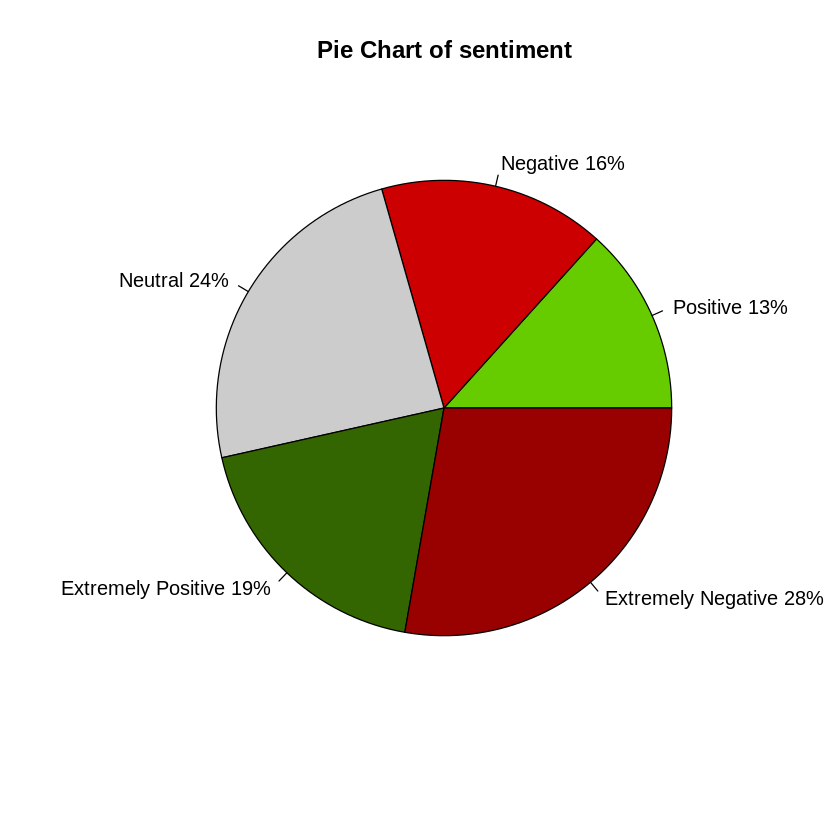

In [8]:
#jpeg("PieChartSentiment.jpg")
sentiment <- c(uniqueSentiment[,c(2)]) 
lbls <- c('Positive','Negative','Neutral','Extremely Positive','Extremely Negative')
#Calcolo percentuali
pct <- round(sentiment/sum(sentiment)*100)
lbls <- paste(lbls, pct) # Aggiunta delle percentuali alle etichette
lbls <- paste(lbls,"%",sep="") 
pie(sentiment,labels = lbls, col=c("#66CC00","#CC0000","#CCCCCC","#336600","#990000"),
   main="Pie Chart of sentiment") 
#dev.off()

---

#### Preparazione train e test per classificazione.
Trasformazione da 5 classi a 3: Positive, Negative, Neutral

---

In [38]:
#Seleziono solo il testo dei tweet e il Sentiment tra train e test iniziale
new_train = data.frame(
                text = train$OriginalTweet,
                labels = train$Sentiment,
                stringsAsFactors=F)

new_test = data.frame(
                text = test$OriginalTweet,
                labels = test$Sentiment,
                stringsAsFactors=F)

In [10]:
#Free memory
rm(train)
rm(test)

In [40]:
# Seleziono solo 3 classi e non 5.

classes_def <- function(x)
    if (x ==  "Extremely Positive"){
         "2"
    }else if( x == "Extremely Negative"){
         "0"
    }else if(x == "Negative"){
         "0"
    }else if(x ==  "Positive"){
         "2"
    }else {
         "1"
    }

new_train$labels = lapply(new_train$labels, function(x) classes_def(x))
new_test$labels = lapply(new_test$labels, function(x) classes_def(x))

#Ricalcolo i valori distinti per il Sentiment dopo il mapping
uniqueSentiment_trasf = count(new_train,labels)
uniqueSentiment_trasf

,labels,n
,<list>,<int>
1,1,7713
2,2,18046
3,0,15398


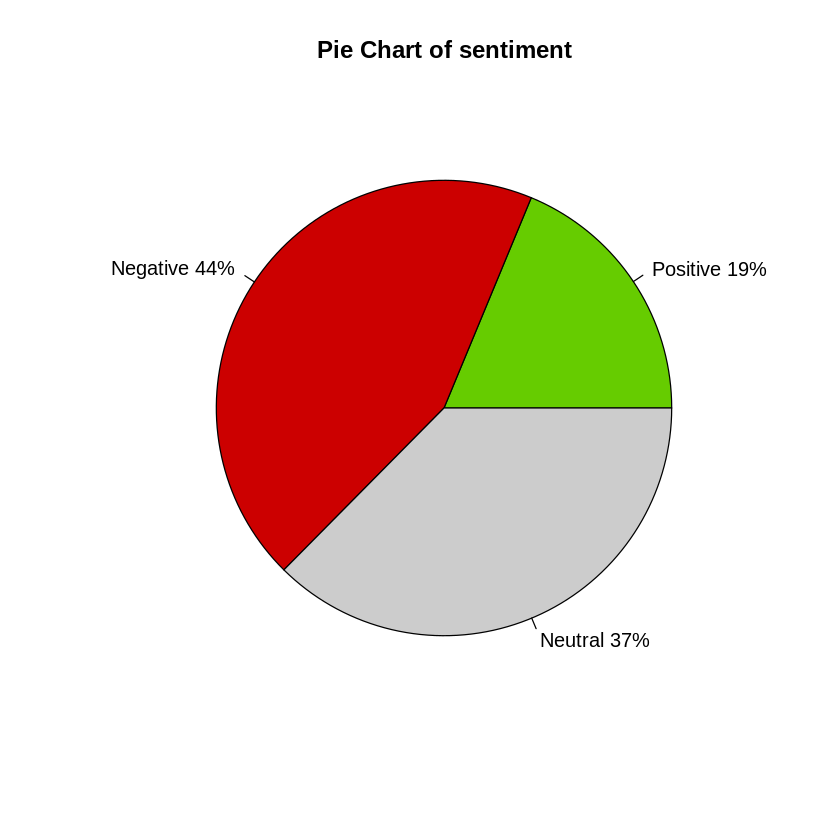

In [12]:
#jpeg("PieChartSentiment.jpg")
sentiment <- c(uniqueSentiment_trasf[,c(2)]) 
lbls <- c('Positive','Negative','Neutral')
pct <- round(sentiment/sum(sentiment)*100)
lbls <- paste(lbls, pct) # add percents to labels
lbls <- paste(lbls,"%",sep="") # ad % to labels
pie(sentiment,labels = lbls, col=c("#66CC00", "#CC0000", "#CCCCCC"),
   main="Pie Chart of sentiment") 
#dev.off()

---

#### Creazione del corpus

---

In [13]:
#Creazione del corpus del training set
train_corpus <- corpus(new_train)
docvars(train_corpus, "Textno") <-
  sprintf("%02d", 1:ndoc(train_corpus)) 

In [14]:
#Ottengo statistiche sul corpus appena generato
train_corpus.stats <- summary(train_corpus)
head(train_corpus.stats, n = 10)

,Text,Types,Tokens,Sentences,labels,Textno
,<chr>,<int>,<int>,<int>,<list>,<chr>
1,text1,7,8,1,1,01
2,text2,33,38,1,2,02
3,text3,16,16,1,2,03
4,text4,41,50,4,2,04
5,text5,39,50,5,0,05
6,text6,36,42,1,2,06
7,text7,28,31,1,2,07
8,text8,14,15,3,1,08
9,text9,43,50,4,2,09


In [15]:
#Cerco i termini vicini con una finestra di 4 per il pattern covid19
head(kwic(train_corpus, "covid19", window=4),10)

,docname,from,to,pre,keyword,post,pattern
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<fct>
1,text630,1,1,,Covid19,panic . Pascal Montagne,covid19
2,text723,27,27,cashier shifts during the,COVID19,pandemic just so the,covid19
3,text1460,46,46,the door . No,Covid19,"in our city ,",covid19
4,text1553,13,13,HELP AMERICAN FAMILIES NO,COVID19,help NO lower drug,covid19
5,text1984,57,57,wont protect you from,covid19,bt will feed the,covid19
6,text4956,20,20,Oil prices collapse and,Covid19,. #Canada #COVID19 #coronavirus,covid19
7,text5427,19,19,m not afraid of,COVID19,but what is scary,covid19
8,text5725,7,7,that priority testing for,COVID19,should be for those,covid19
9,text5851,18,18,AND turnover . With,Covid19,causing people 2 work,covid19


In [16]:
#Cerco i termini vicini con una finestra di 4 per il pattern work
head(kwic(train_corpus, "work", window=4),10)

,docname,from,to,pre,keyword,post,pattern
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<fct>
1,text53,36,36,you lose out on,work,cause your kid has,work
2,text63,2,2,My,work,is capitalizing on the,work
3,text74,28,28,those individuals unable to,work,amp are facing economic,work
4,text86,2,2,I,work,in retail I keep,work
5,text117,4,4,More idiots at,work,causing unnecessary problems of,work
6,text120,24,24,mandating that most employees,work,from home . https://t.co/MhUu7mffPT,work
7,text145,12,12,"distancing , but you",work,retail so you can't,work
8,text165,15,15,. I happen to,work,here . I m,work
9,text175,4,4,And if you,work,at supermarket store you,work


In [17]:
#Cerco i termini vicini con una finestra di 4 per il pattern food
head(kwic(train_corpus, "food", window=4),10)

,docname,from,to,pre,keyword,post,pattern
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<fct>
1,text4,2,2,My,food,stock is not the,food
2,text4,24,24,THERE WILL BE ENOUGH,FOOD,FOR EVERYONE if you,food
3,text5,21,21,", but because my",food,stock is litteraly empty,food
4,text6,32,32,", hand sanitizer ,",food,", toilet paper and",food
5,text12,13,13,increased demand for all,food,products . The wait,food
6,text14,10,10,to stock up on,food,", I'll just have",food
7,text20,12,12,consider donating to a,food,bank or a nonprofit,food
8,text21,26,26,new guilde lines on,food,safty the chinese goverment,food
9,text25,9,9,being done to ensure,food,and other essential products,food


---

#### Text-preprocessing

---

In [18]:
#Mostro il corpus, notiamo menzioni, simboli \n, link, hashtag
head(train_corpus,5)

Corpus consisting of 5 documents and 2 docvars.
text1 :
"@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and ..."

text2 :
"advice Talk to your neighbours family to exchange phone numb..."

text3 :
"Coronavirus Australia: Woolworths to give elderly, disabled ..."

text4 :
"My food stock is not the only one which is empty... PLEASE, ..."

text5 :
"Me, ready to go at supermarket during the #COVID19 outbreak...."

In [19]:
#Generazione dei token dei train partendo dal corpus.
#Si rimuovono numeri, punteggiature, simboli, url e si dividono frasi con "-" centrale
train_token <-
  tokens(
    train_corpus,
    remove_numbers = TRUE,
    remove_punct = TRUE,
    remove_symbols = TRUE,
    remove_url = TRUE,
    split_hyphens = TRUE,
    include_docvars = TRUE
  )

In [20]:
#Si mostra il risultato
head(train_token,20)

Tokens consisting of 20 documents and 2 docvars.
text1 :
[1] "@MeNyrbie"   "@Phil_Gahan" "@Chrisitv"   "and"         "and"        

text2 :
 [1] "advice"     "Talk"       "to"         "your"       "neighbours"
 [6] "family"     "to"         "exchange"   "phone"      "numbers"   
[11] "create"     "contact"   
[ ... and 26 more ]

text3 :
 [1] "Coronavirus" "Australia"   "Woolworths"  "to"          "give"       
 [6] "elderly"     "disabled"    "dedicated"   "shopping"    "hours"      
[11] "amid"        "COVID"      
[ ... and 1 more ]

text4 :
 [1] "My"     "food"   "stock"  "is"     "not"    "the"    "only"   "one"   
 [9] "which"  "is"     "empty"  "PLEASE"
[ ... and 29 more ]

text5 :
 [1] "Me"          "ready"       "to"          "go"          "at"         
 [6] "supermarket" "during"      "the"         "#COVID19"    "outbreak"   
[11] "Not"         "because"    
[ ... and 27 more ]

text6 :
 [1] "As"        "news"      "of"        "the"       "region"    "s"        
 [7] "first" 

In [21]:
#Ulteriore pulizia per #,@,&,https()
token_ungd <- tokens_select(
  train_token,
  c("(http|https)://([^\\s]+)", "<.*?>","#\\w+","@\\w+","\\s+","&\\w+"),
  selection = "remove",
  valuetype = "regex",
  verbose = TRUE
)
#Rimozione delle stop word in base al linguaggio inglese.
toks_nostop <- tokens_select(token_ungd, pattern = stopwords("en"), selection = "remove")
print(toks_nostop)

removed 28,712 features




Tokens consisting of 41,157 documents and 2 docvars.
text1 :
character(0)

text2 :
 [1] "advice"     "Talk"       "neighbours" "family"     "exchange"  
 [6] "phone"      "numbers"    "create"     "contact"    "list"      
[11] "phone"      "numbers"   
[ ... and 15 more ]

text3 :
 [1] "Coronavirus" "Australia"   "Woolworths"  "give"        "elderly"    
 [6] "disabled"    "dedicated"   "shopping"    "hours"       "amid"       
[11] "COVID"       "outbreak"   

text4 :
 [1] "food"     "stock"    "one"      "empty"    "PLEASE"   "panic"   
 [7] "ENOUGH"   "FOOD"     "EVERYONE" "take"     "need"     "Stay"    
[ ... and 3 more ]

text5 :
 [1] "ready"       "go"          "supermarket" "outbreak"    "paranoid"   
 [6] "food"        "stock"       "litteraly"   "empty"       "serious"    
[11] "thing"       "please"     
[ ... and 3 more ]

text6 :
 [1] "news"      "region"    "s"         "first"     "confirmed" "COVID"    
 [7] "case"      "came"      "Sullivan"  "County"    "last"      "w

In [22]:
#Free memory
rm(train_corpus)

---

#### Creazione matrice documenti-termini e applicazione TF-IDF

---

In [23]:
#Creazione matrice termini-documenti portando tutti i token in forma minuscola.
dfm_train <- dfm(toks_nostop,
                       tolower = TRUE,
                       stem = FALSE)
# keep only words occurring >= 10 times and in >= 2 documents
dfm_train_tfidf.trim <- dfm_trim(dfm_train, min_termfreq = 10, min_docfreq = 2)
#Pesatura matrice con TF-IDF
dfm_train_tfidf <- dfm_tfidf(dfm_train_tfidf.trim)
dfm_train_tfidf

Document-feature matrix of: 41,157 documents, 6,171 features (99.8% sparse) and 2 docvars.
       features
docs      advice     talk neighbours   family exchange    phone  numbers
  text1 0        0           0       0        0        0        0       
  text2 2.196142 2.441257    6.06932 1.880444 3.070376 4.894253 5.211687
  text3 0        0           0       0        0        0        0       
  text4 0        0           0       0        0        0        0       
  text5 0        0           0       0        0        0        0       
  text6 0        0           0       0        0        0        0       
       features
docs      create  contact     list
  text1 0        0        0       
  text2 2.535262 2.110653 2.067901
  text3 0        0        0       
  text4 0        0        0       
  text5 0        0        0       
  text6 0        0        0       
[ reached max_ndoc ... 41,151 more documents, reached max_nfeat ... 6,161 more features ]

In [24]:
#Free memory
rm(new_train)

---

#### Generazione wordcloud

---

In [ ]:
#jpeg("wordcloud.jpeg")
set.seed(100)
textplot_wordcloud(dfm_train_tfidf.trim, min_count = 100, random_order = FALSE,
                   rotation = .25, 
                   color = RColorBrewer::brewer.pal(8,"Dark2"))
#dev.off()

---

## **Classificazione**

---

---

##### Funzione per generare la confusion matrix dato un modello e i dati di train e test.

---

In [28]:
#Dato un modello, train e test set calcola la predizione.
#Si ritorna la matrice di confusione con classi predette e quelle attuali.
computeConfusionMatrix <- function(test, train, model) {
  dfmat_matched <- dfm_match(test, features = featnames(train))
  actual_class <- unlist(dfmat_matched$labels)
  predicted_class <- predict(model, newdata = dfmat_matched, force = TRUE)
  tab_class <- table(actual_class,predicted_class)
  confusionMatrix <- confusionMatrix(tab_class, mode = "everything")
  return (confusionMatrix)
}

---

##### Costruzione della matrice termini-document e applicazione TF-IDF per il test set.

---

In [41]:
#Conto quanti record ci sono per ogni Sentiment distinto nel test set
uniqueSentiment_test = count(new_test,labels)
uniqueSentiment_test

,labels,n
,<list>,<int>
1,0,1633
2,2,1546
3,1,619


In [ ]:
#Creazione del corpus, generazione dei token e pulizia come per il training set.
test_corpus <- corpus(new_test)
token <-
  tokens(
    test_corpus,
    remove_numbers = TRUE,
    remove_punct = TRUE,
    remove_symbols = TRUE,
    remove_url = TRUE,
    split_hyphens = TRUE,
    include_docvars = TRUE
  )

token_ungd <- tokens_select(
  token,
  c("(http|https)://([^\\s]+)", "<.*?>","#\\w+","@\\w+","\\s+","&\\w+"),
  selection = "remove",
  valuetype = "regex",
  verbose = TRUE
)
toks_nostop <- tokens_select(token_ungd, pattern = stopwords("en"), selection = "remove")
dfm_test <- dfm(token_ungd,
                       tolower = TRUE,
                       stem = FALSE)
dfm_test_tfidf.trim <- dfm_trim(dfm_test, min_termfreq = 10, min_docfreq = 2)
dfm_test_tfidf <- dfm_tfidf(dfm_test_tfidf.trim)
dfm_test_tfidf

In [30]:
#Free memory
rm(new_test)
rm(test_corpus)


---

## **Naive Bayes Multinomial**

---

In [ ]:
nb_mult <- textmodel_nb(dfm_train_tfidf, unlist(docvars(dfm_train_tfidf, "labels")), distribution = c("multinomial"))

In [34]:
computeConfusionMatrix(dfm_test_tfidf,dfm_train_tfidf, nb_mult)

Confusion Matrix and Statistics

               actual_class
predicted_class    0    1    2
              0 1101  136  267
              1  235  388  188
              2  297   95 1091

Overall Statistics
                                          
               Accuracy : 0.6793          
                 95% CI : (0.6642, 0.6941)
    No Information Rate : 0.43            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4958          
                                          
 Mcnemar's Test P-Value : 1.185e-12       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.6742   0.6268   0.7057
Specificity            0.8139   0.8669   0.8259
Pos Pred Value         0.7320   0.4784   0.7357
Neg Pred Value         0.7681   0.9227   0.8035
Precision              0.7320   0.4784   0.7357
Recall                 0.6742   0.6268   0.7057
F1                     0.7019   0.5427   0.7204
P

---

## **Naive Bayes Bernoulli**

---

In [42]:
nb_bern <- textmodel_nb(dfm_train_tfidf, unlist(docvars(dfm_train_tfidf, "labels")), distribution = c("Bernoulli"))

In [43]:
computeConfusionMatrix(dfm_test_tfidf,dfm_train_tfidf, nb_bern)

Confusion Matrix and Statistics

               actual_class
predicted_class    0    1    2
              0 1016   77  267
              1  391  495  355
              2  226   47  924

Overall Statistics
                                          
               Accuracy : 0.6411          
                 95% CI : (0.6256, 0.6564)
    No Information Rate : 0.43            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4599          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.6222   0.7997   0.5977
Specificity            0.8411   0.7653   0.8788
Pos Pred Value         0.7471   0.3989   0.7719
Neg Pred Value         0.7469   0.9515   0.7609
Precision              0.7471   0.3989   0.7719
Recall                 0.6222   0.7997   0.5977
F1                     0.6789   0.5323   0.6737
P


---

## **Linear SVM**

---

In [44]:
svm <- textmodel_svm(dfm_train_tfidf, y = quanteda::docvars(dfm_train_tfidf, "labels"))

In [45]:
computeConfusionMatrix(dfm_test_tfidf,dfm_train_tfidf, svm)

Confusion Matrix and Statistics

               actual_class
predicted_class    0    1    2
              0 1151   49  184
              1  240  517  174
              2  242   53 1188

Overall Statistics
                                          
               Accuracy : 0.752           
                 95% CI : (0.7379, 0.7656)
    No Information Rate : 0.43            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6151          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.7048   0.8352   0.7684
Specificity            0.8924   0.8698   0.8690
Pos Pred Value         0.8316   0.5553   0.8011
Neg Pred Value         0.8003   0.9644   0.8454
Precision              0.8316   0.5553   0.8011
Recall                 0.7048   0.8352   0.7684
F1                     0.7630   0.6671   0.7844
P


---

## **Logistic regression**

---

In [46]:
log_reg <- textmodel_lr(dfm_train_tfidf, unlist(quanteda::docvars(dfm_train_tfidf, "labels")))

Warning message:
“from glmnet Fortran code (error code -96); Convergence for 96th lambda value not reached after maxit=10000 iterations; solutions for larger lambdas returned”


In [47]:
computeConfusionMatrix(dfm_test_tfidf,dfm_train_tfidf, log_reg)

Confusion Matrix and Statistics

               actual_class
predicted_class    0    1    2
              0 1152   34  159
              1  246  538  172
              2  235   47 1215

Overall Statistics
                                          
               Accuracy : 0.7649          
                 95% CI : (0.7511, 0.7783)
    No Information Rate : 0.43            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6362          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.7055   0.8691   0.7859
Specificity            0.9109   0.8685   0.8748
Pos Pred Value         0.8565   0.5628   0.8116
Neg Pred Value         0.8039   0.9715   0.8561
Precision              0.8565   0.5628   0.8116
Recall                 0.7055   0.8691   0.7859
F1                     0.7737   0.6832   0.7986
P